In [1]:
import numpy as np
import torch
import yaml
import sys
import socket
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
from my_utils import periodic_isometric_grid, periodic_FVM, periodic_derivatives

from utils.dataloader import KF_flow_data

In [2]:
if socket.gethostname() == 'DESKTOP-157DQSC':
    device = torch.device('cpu')
    data_path = r"C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies"#\2D_NS_Re40.npy"
else:
    device = torch.device('cuda')
    data_path = "/home/n.foster/datasets" #2D_NS_Re500.npy"

yaml_file = r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\configs\KF_flow.yaml'
with open(yaml_file, 'r') as file:
    config = yaml.safe_load(file)

train_loader, test_loader, S, max_norm = KF_flow_data(f"{data_path}/{config['dataset_params']['dataset_name']}", 
                                                      config['dataset_params']['split'], 
                                                      batch_size = config['parameters']['batch_size'], 
                                                      sub = config['dataset_params']['sub'], 
                                                      T_in = config['dataset_params']['T_in'], 
                                                      T_out = config['dataset_params']['T_out']
                                                      )

Raw Dataset has shape: (200, 501, 64, 64) with shape 64x64
Dataset is split for training (90%) to 180 - 20 with downsample of 1x
Regularisation of Dataset has maximum norm (at subsample of 1x): 270.80
preprocessing finished, time used: 19.82


In [3]:
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.physics.operators import Divergence_Operator, Gradient_2nd_Operator

In [ ]:
class periodic_FVM(object):
    def __init__(self, S, device='cpu', L=2*np.pi):
        self.mesh = periodic_isometric_grid(L=L, S=S, device=device)
        self.S = S

    def __call__(self, x, **kwargs):
        
        if len(x.shape) == 3:
            x = x.unsqueeze(-1)
        B, S, __, C = x.shape
        x = x.reshape(B,1,S*S,C)

        _, grad_pred = Divergence_Operator.caclulate(self.mesh, field=x)
        grad_2nd_pred = Gradient_2nd_Operator.caclulate(self.mesh, field=x)
        
        # If vorticity function (assuming 2D)
        if x.shape[-1] == 1 :
            grad_dict = {'dwdx':grad_pred[...,0],
                         'dwdy':grad_pred[...,1],
                         'dwdxx':grad_2nd_pred[...,0],
                         'dwdyy':grad_2nd_pred[...,3]
                         }

        # If velocity function (assuming 2D)
        else:
            grad_dict = {'dudx':grad_pred[...,0], 'dvdx':grad_pred[...,1],
                         'dudy':grad_pred[...,2], 'dvdy':grad_pred[...,3],
                         'dudxx':grad_2nd_pred[...,0], 'dvdxx':grad_2nd_pred[...,1],
                         'dudyy':grad_2nd_pred[...,6], 'dvdyy':grad_2nd_pred[...,7]
                         }

        return grad_dict

In [4]:
fvm_mesh = periodic_FVM(S=S)

In [5]:
x, y = next(iter(train_loader))

In [6]:
du_fvm = fvm_mesh(x=x.unsqueeze(-1))
dx1_fvm, dy1_fvm, dx2_fvm, dy2_fvm, lap_pred = [x.reshape(-1,S,S,1) for x in du_fvm]
dx1_fdm, dy1_fdm, dx2_fdm, dy2_fdm = periodic_derivatives(x=x.unsqueeze(-1), dx=2*np.pi/64, dy=2*np.pi/64)

AttributeError: 'str' object has no attribute 'reshape'

In [37]:
def plot(fvm, fdm):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
    ims = []
    ims.append(axs[0].imshow(fvm, origin="lower", aspect="auto"))
    ims.append(axs[1].imshow(fdm, origin="lower", aspect="auto"))
    ims.append(axs[2].imshow(fdm-fvm, origin="lower", aspect="auto", cmap="plasma"))
    print(f'Errors: {(fdm-fvm).mean():.4g} (mean), {(fdm-fvm).max():.4g} (max), {(fdm-fvm).min():.4g} (min)')
    axs[0].set_title("FVM")
    axs[1].set_title("FDM")
    axs[2].set_title("Difference")
    plt.tight_layout()
    plt.show()

Errors: 6.325e-09 (mean), 1.144e-05 (max), -1.121e-05 (min)


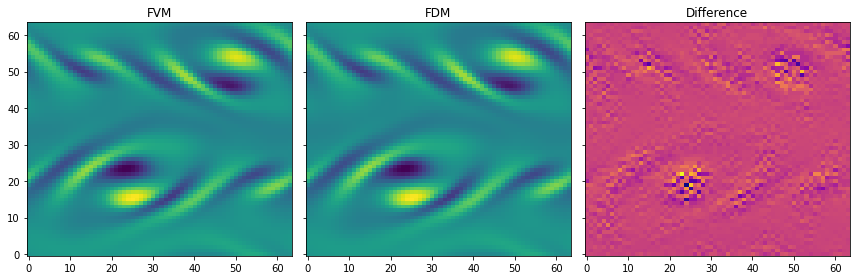

Errors: 3.303e-09 (mean), 1.049e-05 (max), -1.24e-05 (min)


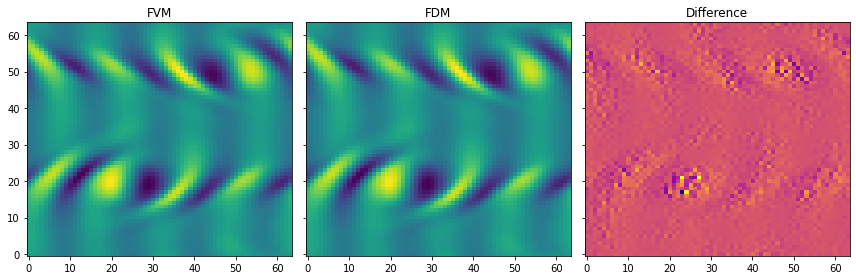

In [20]:
plot(dx1_fvm[0], dx1_fdm[0])
plot(dy1_fvm[0], dy1_fdm[0])

Errors: -6.24e-08 (mean), 33.9 (max), -35.79 (min)


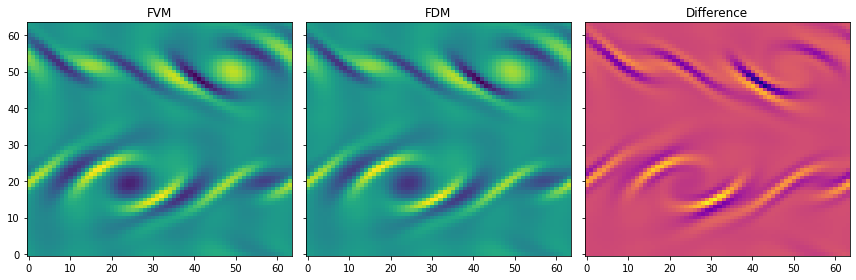

Errors: -4.377e-08 (mean), 35.79 (max), -33.9 (min)


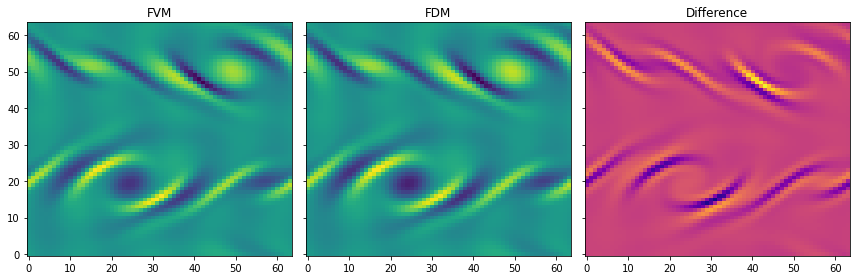

Errors: -1.071e-07 (mean), 5.341e-05 (max), -9.918e-05 (min)


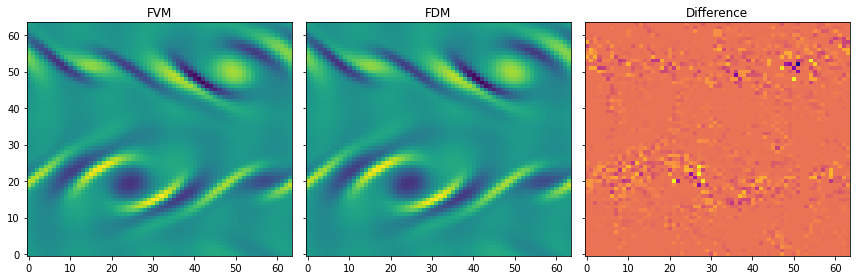

In [22]:

plot(dy2_fvm[0]+dx2_fvm[0], dy2_fdm[0]+dx2_fdm[0])
plot(lap_pred[0], dy2_fvm[0]+dx2_fvm[0])
plot(lap_pred[0], dy2_fdm[0]+dx2_fdm[0])

## Second Order Operator:

In [ ]:
class Gradient_2nd_Operator():
    
    @staticmethod
    def caclulate(self, field: torch.Tensor, field_type:str = 'U') -> torch.Tensor:
        
        if len(field.shape) == 3 and field_type == 'p':
            field.unsqueeze(-1)
        batch_size = field.shape[0]
        time_size = field.shape[1]
        channel_size = field.shape[-1]

        div_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, channel_size), dtype=field.dtype, device=self.device)
        grad_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim, self.mesh.dim*channel_size), dtype=field.dtype, device=self.device)
        
        grad_field = Gradient_2nd_Operator.internal_flux(self, grad_field, field)
        #div_field, grad_field = Divergence_Operator.boundary_flux(self, div_field, grad_field, field, field_type)
        #div_field/= self.mesh.cell_volumes.reshape(1,1,-1,1)
        grad_field/= self.mesh.cell_volumes.reshape(1,1,-1,1,1)
        return grad_field.flatten(start_dim=-2)

    def internal_flux(self, grad_field:torch.tensor, field:torch.tensor, implicit:bool=True, orthogonal:bool=True) -> torch.Tensor:
        idx = self.mesh.internal_faces

        # Orthogonal
        if orthogonal:
            orth_vector = self.delta[idx]
            orth_vector_mag = self.delta_mag[idx]
        else:
            orth_vector = self.k_vector[idx]
            orth_vector_mag = self.k_vector_mag[idx]
        
        if implicit:
            face_gradients = torch.einsum('btfd,fe->btfed', (field[:,:,self.mesh.face_neighbors[idx], :] - field[:,:,self.mesh.face_owners[idx],:]), self.d[idx])*(1/self.d_mag[idx]).reshape(1,1,-1,1,1)
            face_gradients = face_gradients.flatten(start_dim=-2)
            gradient = torch.einsum('btfd,fe->btfed', face_gradients, orth_vector[idx]) # note orth vector has area encoded
        else:
            raise NotImplementedError

        print(self.mesh.face_owners[idx].shape, gradient.shape, grad_field.shape)
        grad_field.index_add_(2, self.mesh.face_owners[idx], gradient)
        grad_field.index_add_(2, self.mesh.face_neighbors[idx], -gradient)

        return grad_field

In [39]:
B, S, __ = x.shape
x_new = x.reshape(B,1,S*S,1)
order_2_grads = Gradient_2nd_Operator.caclulate(fvm_mesh.mesh, field=x_new)
order_2_grads = order_2_grads.reshape(-1,S,S,4)
order_2_grads.shape

torch.Size([50, 64, 64, 4])

In [41]:
x_in = x
if len(x.shape) == 3:
    x_in = x.unsqueeze(-1)
B, S, __, C = x_in.shape
x_in = x_in.reshape(B,1,S*S,C)

_, grad_pred = Divergence_Operator.caclulate(fvm_mesh.mesh, field=x_in)
__, order_2_grads_explicit = Divergence_Operator.caclulate(fvm_mesh.mesh, field=grad_pred)
order_2_grads_explicit = order_2_grads_explicit.reshape(B,S,S,4)

In [35]:
order_2_grads_explicit.shape

torch.Size([50, 1, 4096, 4])

Errors: -1.024e-08 (mean), 12.67 (max), -13.89 (min)


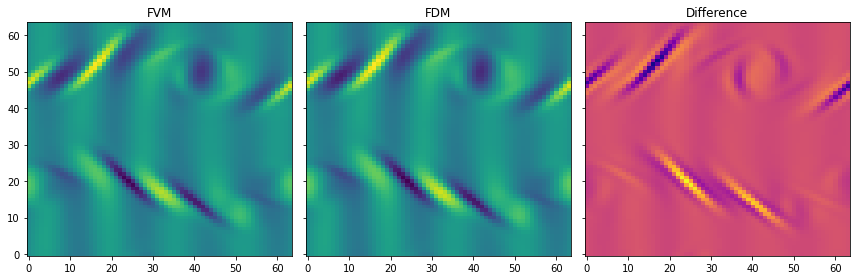

In [42]:
plot(order_2_grads[0,...,[3]], order_2_grads_explicit[0,...,[3]])

Errors: -4.585e-09 (mean), 4.959e-05 (max), -4.959e-05 (min)


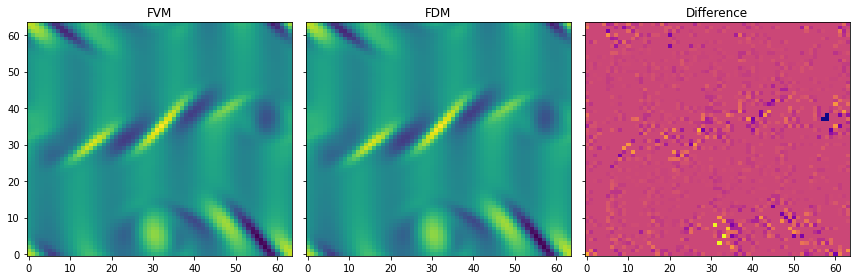

In [135]:
plot(order_2_grads[0,...,[3]], dy2_fdm[0])

dwdxy and dwdyx should equal zero in the laminar regime where there are no turbulent pertubations

### Plots for Thesis

In [28]:
figure_path = r"C:\Users\Noahc\Documents\USYD\PHD\4 - Latex_new\00_figures\06_mno\kf"
latex_textwidth_in_inches = 6.5  # change as needed
px_width = latex_textwidth_in_inches * 96

In [30]:
du_fvm_from_git = fvm_mesh(x=x.unsqueeze(-1))
du_fdm_from_git = periodic_derivatives(x=x.unsqueeze(-1), dx=2*np.pi/64, dy=2*np.pi/64)

In [43]:
import plotly.subplots as subplots
import plotly.graph_objects as go

# comparison

rows=1
cols=3
fig = subplots.make_subplots(rows,cols, subplot_titles=('FDM','FVM', 'Difference'))
#fig.add_trace(go.Heatmap(z=du_fvm['dwdx'][0,...,0], showscale=False),1,1)
fig.add_trace(go.Heatmap(z=du_fdm_from_git['dwdx'][0,...,0], showscale=False, coloraxis='coloraxis1'),1,1)
fig.add_trace(go.Heatmap(z=du_fvm_from_git['dwdx'][0,...,0], showscale=False, coloraxis='coloraxis1'),1,2)
fig.add_trace(go.Heatmap(z=(du_fvm_from_git['dwdx']-du_fdm_from_git['dwdx'])[0,...,0], showscale=True, coloraxis='coloraxis2'),1,3)
#fig.add_trace(go.Heatmap(z=first_soblev[0,...,0].real, showscale=False),1,3)
for i in range(1, rows*cols + 1):
    fig.update_xaxes(scaleanchor=f"y{i}", ticks='', scaleratio=1, linecolor='rgba(0,0,0,0)', showgrid=False, showticklabels=False, row=(i-1)//cols + 1, col=(i-1)%cols + 1)
    fig.update_yaxes(constrain='domain', ticks='', linecolor='rgba(0,0,0,0)', showgrid=False, showticklabels=False, row=(i-1)//cols + 1, col=(i-1)%cols + 1)
fig.update_layout(
    font=dict(family="Times New Roman", size=11), template = "simple_white",
    #xaxis=dict(showticklabels=True, showgrid=True, zeroline=False, linecolor='rgba(0,0,0,0)', title='Angle', scaleanchor='y', scaleratio=1.5, title_standoff=0),
    #yaxis=dict(showticklabels=True, showgrid=True, zeroline=False, linecolor='rgba(0,0,0,0)', title='Radius'),
    plot_bgcolor='rgba(0,0,0,0)',    # Background color inside the plot area
    width=px_width, showlegend=False, margin=dict(l=20, r=0, t=20, b=10), height = px_width/3, 
    coloraxis1=dict(colorscale='Viridis', showscale=False),
    coloraxis2=dict(colorscale='RdBu', showscale=True)
)
for i in range(len(fig.layout.annotations)):
   fig.layout.annotations[i].y = 0.93  # Adjust y coordinate closer to plot
fig.show()
fig.write_image(f"{figure_path}/MNO_KF40_dwdx_FVM.pdf")

In [74]:
order_2_grads_explicit.shape

torch.Size([50, 64, 64, 4])

In [77]:
import plotly.subplots as subplots
import plotly.graph_objects as go

# comparison

rows=2
cols=3
fig = subplots.make_subplots(rows,cols,vertical_spacing=0.05, subplot_titles=('FDM','FVM', 'Difference'))
#fig.add_trace(go.Heatmap(z=du_fvm['dwdx'][0,...,0], showscale=False),1,1)
fig.add_trace(go.Heatmap(z=du_fdm_from_git['dwdxx'][0,...,0], showscale=False, coloraxis='coloraxis1'),1,1)
fig.add_trace(go.Heatmap(z=order_2_grads_explicit[0,...,0], showscale=False, coloraxis='coloraxis1'),1,2)
fig.add_trace(go.Heatmap(z=(order_2_grads_explicit[0,...,0]-du_fdm_from_git['dwdxx'][0,...,0]), showscale=True, coloraxis='coloraxis2', zmid=0),1,3)

fig.add_trace(go.Heatmap(z=du_fvm_from_git['dwdxx'][0,...,0], showscale=False, coloraxis='coloraxis1'),2,2)
fig.add_trace(go.Heatmap(z=(du_fvm_from_git['dwdxx']-du_fdm_from_git['dwdxx'])[0,...,0], showscale=True, coloraxis='coloraxis3', zmid=0),2,3)
#fig.add_trace(go.Heatmap(z=first_soblev[0,...,0].real, showscale=False),1,3)
for i in range(1, rows*cols + 1):
    fig.update_xaxes(scaleanchor=f"y{i}", ticks='', scaleratio=1, linecolor='rgba(0,0,0,0)', showgrid=False, showticklabels=False, row=(i-1)//cols + 1, col=(i-1)%cols + 1)
    fig.update_yaxes(constrain='domain', ticks='', linecolor='rgba(0,0,0,0)', showgrid=False, showticklabels=False, row=(i-1)//cols + 1, col=(i-1)%cols + 1)
fig.update_layout(
    font=dict(family="Times New Roman", size=11), template = "simple_white",
    #xaxis=dict(showticklabels=True, showgrid=True, zeroline=False, linecolor='rgba(0,0,0,0)', title='Angle', scaleanchor='y', scaleratio=1.5, title_standoff=0),
    #yaxis=dict(showticklabels=True, showgrid=True, zeroline=False, linecolor='rgba(0,0,0,0)', title='Radius'),
    plot_bgcolor='rgba(0,0,0,0)',    # Background color inside the plot area
    width=px_width, showlegend=False, margin=dict(l=20, r=0, t=20, b=10), height = px_width/2, 
    coloraxis1=dict(colorscale='Viridis', showscale=False),
    coloraxis2=dict(colorscale='RdBu', showscale=True, colorbar=dict(len=0.54, y=0.763), cmid=0),
    coloraxis3=dict(colorscale='RdBu', showscale=True, colorbar=dict(len=0.54, y=0.238), cmid=0),
    yaxis2=dict(title='Explicit',title_standoff=0),
    yaxis5=dict(title='Implicit',title_standoff=0),
)
# for i in range(len(fig.layout.annotations)):
#    fig.layout.annotations[i].y = 0.93  # Adjust y coordinate closer to plot
fig.show()
fig.write_image(f"{figure_path}/MNO_KF40_dwdxx_FVM.pdf")

In [ ]:
fig = go.Figure(
    data=go.Heatmap(
        z=np.sqrt(U_mapped[...,0]**2 + U_mapped[...,1]**2),    # data matrix [m (radius), n (angle)]
        colorscale='Viridis',  # colorscale choice
        x=angles,   # angular indices
        y=radii,   # radial indices
        hoverongaps=False,
        zsmooth=False,
        showscale=False
    )
)
fig.update_layout(
    font=dict(family="Times New Roman", size=11), template = "simple_white",
    xaxis=dict(showticklabels=True, showgrid=True, zeroline=False, linecolor='rgba(0,0,0,0)', title='Angle', scaleanchor='y', scaleratio=1.5, title_standoff=0),
    yaxis=dict(showticklabels=True, showgrid=True, zeroline=False, linecolor='rgba(0,0,0,0)', title='Radius'),
    plot_bgcolor='rgba(0,0,0,0)',    # Background color inside the plot area
    width=px_width/2, showlegend=False, margin=dict(l=20, r=10, t=20, b=10), height = px_width/2, 
)

## Cartesian Velocity
lets extend this to cartesian velocity components

In [ ]:
from utilities import w_to_u
x2 = w_to_u(x)
x2.shape

torch.Size([50, 64, 64, 2])

In [98]:
dx1_fdm2, dy1_fdm2, dx2_fdm2, dy2_fdm2 = periodic_derivatives(x=x2, dx=2*np.pi/64, dy=2*np.pi/64)

In [ ]:
B, S, __, C = x2.shape
x2_in = x2.reshape(B,1,S*S,C)

#x = torch.nn.functional.pad(x, (0, 1)) # 2D->3D
print(x.shape)
_, grad_pred2 = Divergence_Operator.caclulate(fvm_mesh.mesh, field=x2_in, field_type='U') #output is [dudx,dvdx,dudy,dvdy]
grad_pred2 = grad_pred2.reshape(-1,S,S,4)

torch.Size([50, 64, 64])


Errors: -5.828e-10 (mean), 2.578e-06 (max), -2.623e-06 (min)


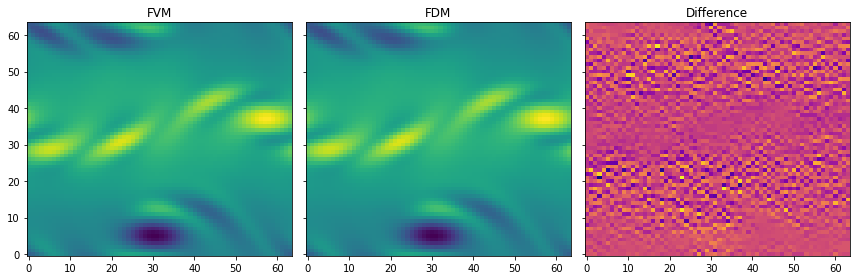

Errors: -5.126e-10 (mean), 1.788e-06 (max), -1.937e-06 (min)


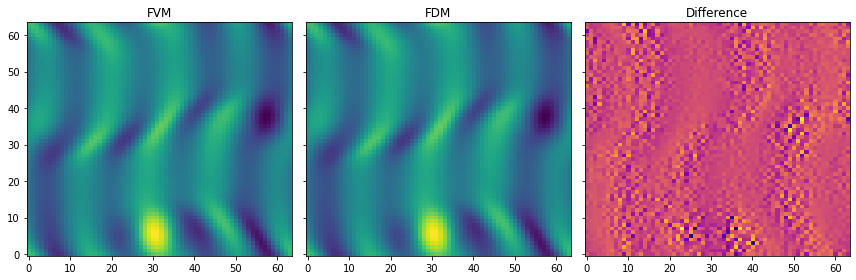

In [136]:
plot(grad_pred2[0,...,1], dx1_fdm2[0,...,1])
plot(grad_pred2[0,...,2], dy1_fdm2[0,...,0])

In [ ]:
order_2_grads2 = Gradient_2nd_Operator.caclulate(fvm_mesh.mesh, field=x2_in) #output [dudxx dvdxx, .... , dudyy, dvdyy]
order_2_grads2 = order_2_grads2.reshape(-1,S,S,8)
order_2_grads2.shape

torch.Size([8192]) torch.Size([50, 1, 8192, 2, 4]) torch.Size([50, 1, 4096, 2, 4])


torch.Size([50, 64, 64, 8])

Errors: 4.102e-09 (mean), 6.199e-06 (max), -7.629e-06 (min)


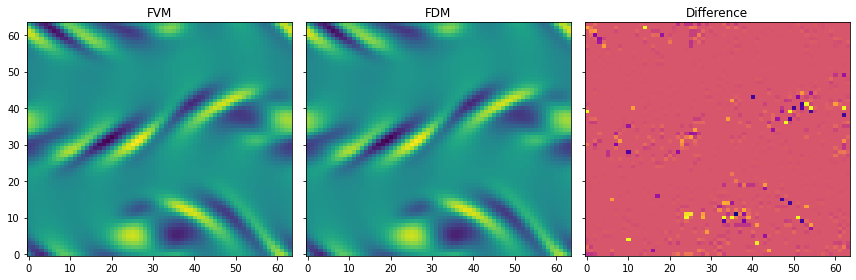

Errors: -4.072e-09 (mean), 7.629e-06 (max), -7.629e-06 (min)


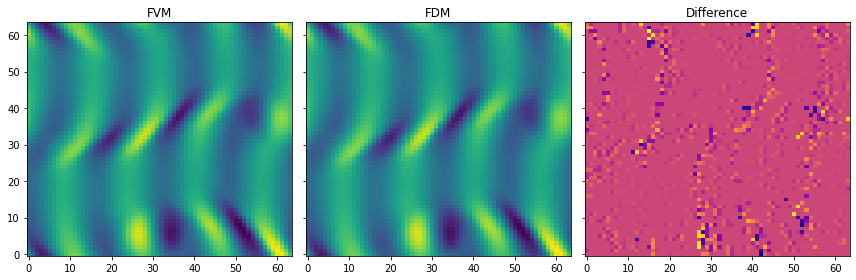

In [138]:
plot(order_2_grads2[0,...,0], dx2_fdm2[0,...,0])
plot(order_2_grads2[0,...,6], dy2_fdm2[0,...,0])

## Experiments:

In [9]:
x_small = x[:,::2,::2]
S_2 = x_small.shape[-1]
fvm_mesh_val = periodic_FVM(S=S_2)
du_fvm = fvm_mesh_val(x=x_small.unsqueeze(-1))
dx1_fvm, dy1_fvm, dx2_fvm, dy2_fvm, lap_pred = [i.reshape(-1,S_2,S_2,1) for i in du_fvm]
dx1_fdm, dy1_fdm, dx2_fdm, dy2_fdm = periodic_derivatives(x=x_small.unsqueeze(-1), dx=2*np.pi/S_2, dy=2*np.pi/S_2)

torch.Size([50, 1, 1024, 1])
torch.Size([50, 1, 1024, 4])


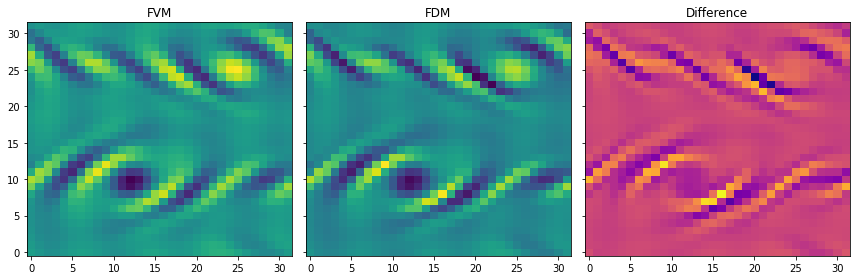

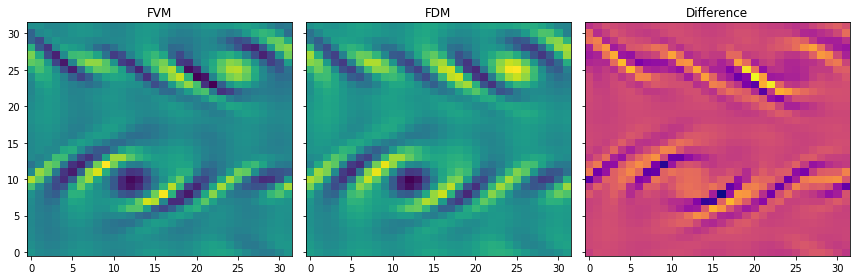

In [10]:
#plot(dx2_fvm[0], dx2_fdm[0])
#plot(dy2_fvm[0], dy2_fdm[0])
plot(dy2_fvm[0]+dx2_fvm[0], dy2_fdm[0]+dx2_fdm[0])
plot(lap_pred[0], dy2_fvm[0]+dx2_fvm[0])

In [47]:
fvm_mesh_val.mesh.d_mag.min()

tensor(0.1963)

In [22]:

import plotly.graph_objects as go

In [57]:
fvm_mesh_val = periodic_FVM(S=4)

In [52]:
fvm_mesh_val.mesh.delta.shape

torch.Size([2048, 2])

In [68]:
len(fvm_mesh_val.mesh.mesh.face_owners)

32

In [66]:
fvm_mesh_val.mesh.mesh.cell_center_vectors.shape

torch.Size([32, 2])

In [69]:
normals = fvm_mesh_val.mesh.mesh.cell_center_vectors #*fvm_mesh_val.mesh.d_mag[:,None]
owner = fvm_mesh_val.mesh.mesh.face_owners
neighbour = fvm_mesh_val.mesh.mesh.face_neighbors
coords_r = fvm_mesh_val.mesh.mesh.cell_centers

In [70]:
ARROW_LENGTH = np.pi/(2*S)
arrowo_x, arrowo_y, arrowo_x_end, arrowo_y_end = [], [], [], []
arrown_x, arrown_y, arrown_x_end, arrown_y_end = [], [], [], []
for face_idx in range(len(owner)):
    face_normal = normals[face_idx].numpy()
    arrow_vec = ARROW_LENGTH * face_normal
    
    # Outgoing arrow (when cell is owner): from center → center + normal
    owner_cell = owner[face_idx].item()
    owner_center = coords_r[owner_cell]
    arrowo_x.append(owner_center[0])
    arrowo_y.append(owner_center[1])
    arrowo_x_end.append(owner_center[0] + arrow_vec[0])
    arrowo_y_end.append(owner_center[1] + arrow_vec[1])
    
    # Incoming arrow (when cell is neighbour): from center - normal → center  
for face_idx in range(len(neighbour)):
    face_normal = normals[face_idx].numpy()
    arrow_vec = ARROW_LENGTH * face_normal
    
    neigh_cell = neighbour[face_idx].item()
    neigh_center = coords_r[neigh_cell]
    arrown_x.append(neigh_center[0] - arrow_vec[0])
    arrown_y.append(neigh_center[1] - arrow_vec[1])
    arrown_x_end.append(neigh_center[0])
    arrown_y_end.append(neigh_center[1])

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=coords_r[:,0], y=coords_r[:,1],
    mode='markers',
    marker=dict(color='green', size=10),
    name='Cell Centres',
    showlegend=False
))
for i in range(len(owner)):
    fig.add_annotation(ax=arrowo_x[i],ay=arrowo_y[i],
    x=arrowo_x_end[i], y=arrowo_y_end[i],
    xref="x", yref="y",axref="x", ayref="y",arrowhead=2,arrowsize=1.5,arrowwidth=2,showarrow=True, arrowcolor='Blue')
for i in range(len(neighbour)):
    fig.add_annotation(ax=arrown_x[i],ay=arrown_y[i],
    x=arrown_x_end[i], y=arrown_y_end[i],
    xref="x", yref="y",axref="x", ayref="y",arrowhead=2,arrowsize=1.5,arrowwidth=2,showarrow=True, arrowcolor='Red')

fig.update_layout(
    xaxis=dict(range=[0, 2*np.pi], showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
    yaxis=dict(range=[0, 2*np.pi], showgrid=True, gridwidth=0.5, gridcolor='lightgray'),
    width=800, height=800,
    hovermode='closest'
)
fig.show()